# Task 5 - Some Other Variants

In [17]:
import os
import wandb
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, TensorDataset, random_split
from matplotlib.image import imread

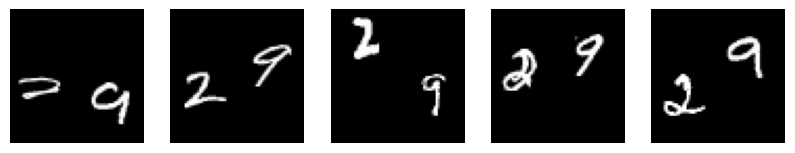

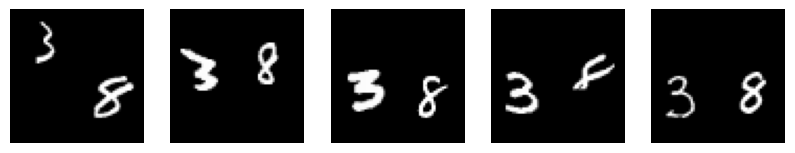

In [44]:
sample_digit_dir = os.path.join("./Data", "Double_MNIST/train", "29")
sample_digit_filenames = [name for name in os.listdir(sample_digit_dir) if name.endswith(".png")]

plt.figure(figsize=(10, 5))
for index, filename in enumerate(sample_digit_filenames[:5]):
    sample_digit_path = os.path.join(sample_digit_dir, filename)
    sample_digit = imread(sample_digit_path)
    plt.subplot(1, 5, index + 1)
    plt.imshow(sample_digit, cmap="gray")
    plt.axis("off")

sample_digit_dir = os.path.join("./Data", "Double_MNIST/train", "38")
sample_digit_filenames = [name for name in os.listdir(sample_digit_dir) if name.endswith(".png")]

plt.figure(figsize=(10, 5))
for index, filename in enumerate(sample_digit_filenames[:5]):
    sample_digit_path = os.path.join(sample_digit_dir, filename)
    sample_digit = imread(sample_digit_path)
    plt.subplot(1, 5, index + 1)
    plt.imshow(sample_digit, cmap="gray")
    plt.axis("off")

In [21]:
double_mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

class DMNIST_Dataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(DMNIST_Dataset, self).__init__(root, transform=transform)

    def __getitem__(self, index):
        path, _ = self.samples[index]
        
        sample  = self.loader(path)
        sample  = self.transform(sample)
        
        target  = int(os.path.basename(os.path.dirname(path)))
        
        return sample, target

    def __len__(self):
        return len(self.samples)

In [22]:
dmnist_train_dataset = DMNIST_Dataset(root="./Data/Double_MNIST/train", transform=double_mnist_transform)
dmnist_val_dataset   = DMNIST_Dataset(root="./Data/Double_MNIST/val",   transform=double_mnist_transform)
dmnist_test_dataset  = DMNIST_Dataset(root="./Data/Double_MNIST/test",  transform=double_mnist_transform)

dmnist_train_loader = DataLoader(dmnist_train_dataset, batch_size=64, shuffle=True)
dmnist_val_loader   = DataLoader(dmnist_val_dataset,   batch_size=64, shuffle=False)
dmnist_test_loader  = DataLoader(dmnist_test_dataset,  batch_size=64, shuffle=False)

## Task 5.1 - Multi-digit Recognition on Multi-MNIST Dataset

## Task 5.1.1 - MLP on Multi-MNIST

In [34]:
class DMNIST_MLP(nn.Module):
    def __init__(self, in_features=784, num_layers=3, num_neurons=[256, 128, 64], out_features=10, dropout_rate=0.2, lr=0.001, num_epochs=10):
        super(DMNIST_MLP, self).__init__()
        
        self.lr           = lr
        self.num_epochs   = num_epochs
        self.in_features  = in_features
        self.num_layers   = num_layers
        self.num_neurons  = num_neurons
        self.out_features = out_features
        
        self.in_layer = nn.Sequential(
            nn.Linear(in_features, num_neurons[0]),
            nn.ReLU()
        )
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers - 1):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(num_neurons[i], num_neurons[i + 1]),
                nn.ReLU()
            ))

        self.out_layer = nn.Sequential(
            nn.Linear(num_neurons[-1], out_features),
            nn.ReLU()
        )

        self.dropout   = nn.Dropout(dropout_rate)
        self.loss      = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
    def forward(self, X):
        X = X.view(-1, self.in_features)
        
        X = self.in_layer(X)
        
        for hidden_layer in self.hidden_layers:
            X = hidden_layer(X)
        
        X = self.dropout(X)
        X = self.out_layer(X)

        return X
    
    def train_MLP(self, left_half_model, right_half_model, train_data, val_data, progress=True):
        train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
        
        train_loss        = []
        val_loss          = []
        pred_train_labels = []
        true_train_labels = []
        pred_val_labels   = []
        true_val_labels   = []

        for epoch in range(self.num_epochs):
            left_half_model.train()
            right_half_model.train()

            epoch_train_loss = 0

            for image_data, target in train_loader:
                left_half_data = image_data.clone()
                left_half_data[:, :, :, (image_data.shape[3] // 2):] = left_half_data[:, :, :, :image_data.shape[3] // 2]

                left_half_model.zero_grad()

                left_half_output = left_half_model(left_half_data)

                left_half_loss = self.loss(left_half_output, target // 10)
                left_half_loss.backward()
                left_half_model.optimizer.step()

                epoch_train_loss += left_half_loss.item()

                right_half_data = image_data.clone()
                right_half_data[:, :, :, :image_data.shape[3] // 2]  = right_half_data[:, :, :, (image_data.shape[3] // 2):]
                
                right_half_model.zero_grad()

                right_half_output = right_half_model(right_half_data)

                right_half_loss = self.loss(right_half_output, target % 10)
                right_half_loss.backward()
                right_half_model.optimizer.step()

                epoch_train_loss += right_half_loss.item()

                if epoch == self.num_epochs - 1:
                    left_output = torch.max(left_half_output, 1)[1].long()
                    right_output = torch.max(right_half_output, 1)[1].long()

                    pred_train_labels += (left_output * 10 + right_output).tolist()
                    true_train_labels += target.tolist()

            epoch_train_loss /= len(train_loader)
            train_loss.append(epoch_train_loss)

            left_half_model.eval()
            right_half_model.eval()
            epoch_val_loss = 0

            for image_data, target in val_loader:
                left_half_data = image_data.clone()
                left_half_data[:, :, :, (image_data.shape[3] // 2):] = left_half_data[:, :, :, :image_data.shape[3] // 2]

                left_half_output = left_half_model(left_half_data)

                left_half_loss = self.loss(left_half_output, target // 10)
                epoch_val_loss += left_half_loss.item()

                right_half_data = image_data.clone()
                right_half_data[:, :, :, :image_data.shape[3] // 2]  = right_half_data[:, :, :, (image_data.shape[3] // 2):]
                
                right_half_output = right_half_model(right_half_data)

                right_half_loss = self.loss(right_half_output, target % 10)
                epoch_val_loss += right_half_loss.item()

                if epoch == self.num_epochs - 1:
                    left_output = torch.max(left_half_output, 1)[1].long()
                    right_output = torch.max(right_half_output, 1)[1].long()

                    pred_val_labels += (left_output * 10 + right_output).tolist()
                    true_val_labels += target.tolist()

            epoch_val_loss /= len(val_loader)
            val_loss.append(epoch_val_loss)

            if progress is True:
                print(f'Epoch {epoch + 1} / {self.num_epochs} ----- Train Loss: {epoch_train_loss} ----- Val Loss: {epoch_val_loss}')

        return train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels
    
    def test_MLP(self, left_half_model, right_half_model, test_data):
        test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

        left_half_model.eval()
        right_half_model.eval()

        test_loss = 0
        pred_test_labels = []
        true_test_labels = []

        for image_data, target in test_loader:
            left_half_data = image_data.clone()
            left_half_data[:, :, :, (image_data.shape[3] // 2):] = left_half_data[:, :, :, :image_data.shape[3] // 2]

            left_half_output = left_half_model(left_half_data)

            left_half_loss = self.loss(left_half_output, target // 10)
            test_loss += left_half_loss.item()

            right_half_data = image_data.clone()
            right_half_data[:, :, :, :image_data.shape[3] // 2]  = right_half_data[:, :, :, (image_data.shape[3] // 2):]
            
            right_half_output = right_half_model(right_half_data)

            right_half_loss = self.loss(right_half_output, target % 10)
            test_loss += right_half_loss.item()

            left_output = torch.max(left_half_output, 1)[1].long()
            right_output = torch.max(right_half_output, 1)[1].long()

            pred_test_labels += (left_output * 10 + right_output).tolist()
            true_test_labels += target.tolist()

        test_loss /= len(test_loader)

        print(f'Test Loss: {test_loss}')

        return test_loss, pred_test_labels, true_test_labels

In [35]:
# Train the model
dmnist_mlp_left  = DMNIST_MLP()
dmnist_mlp_right = DMNIST_MLP()
dmnist_mlp       = DMNIST_MLP()

train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = dmnist_mlp.train_MLP(dmnist_mlp_left, dmnist_mlp_right, dmnist_train_dataset, dmnist_val_dataset)

train_acc = np.sum(np.array(pred_train_labels) == np.array(true_train_labels)) / len(pred_train_labels)
val_acc   = np.sum(np.array(pred_val_labels) == np.array(true_val_labels)) / len(pred_val_labels)

print(f'Train Accuracy: {train_acc} ----- Val Accuracy: {val_acc}')

Epoch 1 / 10 ----- Train Loss: 4.090498095011189 ----- Val Loss: 4.233472093327404
Epoch 2 / 10 ----- Train Loss: 3.811857575337672 ----- Val Loss: 4.023968846286269
Epoch 3 / 10 ----- Train Loss: 3.480143538501721 ----- Val Loss: 3.56476524894096
Epoch 4 / 10 ----- Train Loss: 3.0874836998844377 ----- Val Loss: 3.4375257889429727
Epoch 5 / 10 ----- Train Loss: 2.7783831693685257 ----- Val Loss: 3.139341983357317
Epoch 6 / 10 ----- Train Loss: 2.5634145591670867 ----- Val Loss: 2.967355209526066
Epoch 7 / 10 ----- Train Loss: 2.3648250570697504 ----- Val Loss: 2.8600324817835334
Epoch 8 / 10 ----- Train Loss: 2.2125079159028918 ----- Val Loss: 2.820979543472534
Epoch 9 / 10 ----- Train Loss: 2.0831274459831906 ----- Val Loss: 2.5106255502597383
Epoch 10 / 10 ----- Train Loss: 1.9670782356076577 ----- Val Loss: 2.5903144387111543
Train Accuracy: 0.46577661132348186 ----- Val Accuracy: 0.30428571428571427


In [36]:
# Test the model
test_loss, pred_test_labels, true_test_labels = dmnist_mlp.test_MLP(dmnist_mlp_left, dmnist_mlp_right, dmnist_test_dataset)

test_acc = np.sum(np.array(pred_test_labels) == np.array(true_test_labels)) / len(pred_test_labels)

print(f'Test Accuracy: {test_acc}')

Test Loss: 2.8664918698846025
Test Accuracy: 0.26744444444444443


## Task 5.1.2 - CNN on Multi-MNIST

In [38]:
class DMNIST_CNN(nn.Module):
    def __init__(self, lr=0.001, batch_size=64, kernel_size=3, stride=2, num_epochs=10, dropout_rate=0.2, padding=1):
        super(DMNIST_CNN, self).__init__()
        self.lr           = lr
        self.batch_size   = batch_size
        self.kernel_size  = kernel_size
        self.stride       = stride
        self.num_epochs   = num_epochs
        self.dropout_rate = dropout_rate if dropout_rate is not None else 0
        self.padding      = padding

        self.conv1     = nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.out_dim1  = int((28 + 2*self.padding - self.kernel_size)/self.stride + 1)
        self.out_pool1 = int(self.out_dim1 / 2)

        self.conv2     = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.out_dim2  = int((self.out_pool1 + 2*self.padding - self.kernel_size)/self.stride + 1)
        self.out_pool2 = int(self.out_dim2 / 2)

        self.relu      = nn.ReLU()
        self.pool      = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout   = nn.Dropout(self.dropout_rate)
        self.fc        = nn.Linear(in_features=32 * self.out_pool2 * self.out_pool2, out_features=10)
        self.softmax   = nn.Softmax(dim=1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.loss      = nn.CrossEntropyLoss()

    def forward(self, X, feature_map=False):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.pool(X)

        X = self.conv2(X)
        X = self.relu(X)
        X = self.pool(X)

        X_feature = X

        X = X.view(-1, 32 * self.out_pool2 * self.out_pool2)

        X = self.dropout(X)
        X = self.fc(X)
        X = self.softmax(X)

        if feature_map is True:
            return X, X_feature
        else:
            return X
    
    def train_CNN(self, left_half_model, right_half_model, train_data, val_data, progress=True):
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=self.batch_size, shuffle=True)
        val_loader   = torch.utils.data.DataLoader(dataset=val_data,   batch_size=self.batch_size, shuffle=False)

        train_loss        = []
        val_loss          = []
        pred_train_labels = []
        true_train_labels = []
        pred_val_labels   = []
        true_val_labels   = []

        for epoch in range(self.num_epochs):
            left_half_model.train()
            right_half_model.train()

            epoch_train_loss = 0

            for X, y in train_loader:
                X_left  = X.clone()
                X_right = X.clone()

                X_left[:, :, :, (X.shape[3] // 2):] = X_left[:, :, :, :X.shape[3] // 2]
                X_right[:, :, :, :X.shape[3] // 2]  = X_right[:, :, :, (X.shape[3] // 2):]

                left_half_model.zero_grad()

                left_half_output = left_half_model(X_left)

                left_half_loss = self.loss(left_half_output, y // 10)
                left_half_loss.backward()
                left_half_model.optimizer.step()

                epoch_train_loss += left_half_loss.item()

                right_half_model.zero_grad()

                right_half_output = right_half_model(X_right)

                right_half_loss = self.loss(right_half_output, y % 10)
                right_half_loss.backward()
                right_half_model.optimizer.step()

                epoch_train_loss += right_half_loss.item()

                if epoch == self.num_epochs - 1:
                    left_output  = torch.max(left_half_output, 1)[1].long()
                    right_output = torch.max(right_half_output, 1)[1].long()

                    pred_train_labels += (left_output * 10 + right_output).tolist()
                    true_train_labels += y.tolist()

            epoch_train_loss /= len(train_loader)
            train_loss.append(epoch_train_loss)

            left_half_model.eval()
            right_half_model.eval()

            epoch_val_loss = 0

            for X, y in val_loader:
                X_left  = X.clone()
                X_right = X.clone()

                X_left[:, :, :, (X.shape[3] // 2):] = X_left[:, :, :, :X.shape[3] // 2]
                X_right[:, :, :, :X.shape[3] // 2]  = X_right[:, :, :, (X.shape[3] // 2):]

                left_half_output = left_half_model(X_left)

                left_half_loss = self.loss(left_half_output, y // 10)
                epoch_val_loss += left_half_loss.item()

                right_half_output = right_half_model(X_right)

                right_half_loss = self.loss(right_half_output, y % 10)
                epoch_val_loss += right_half_loss.item()

                if epoch == self.num_epochs - 1:
                    left_output  = torch.max(left_half_output, 1)[1].long()
                    right_output = torch.max(right_half_output, 1)[1].long()

                    pred_val_labels += (left_output * 10 + right_output).tolist()
                    true_val_labels += y.tolist()

            epoch_val_loss /= len(val_loader)
            val_loss.append(epoch_val_loss)

            if progress is True:
                print(f'Epoch {epoch + 1} / {self.num_epochs} ----- Train Loss: {epoch_train_loss} ----- Val Loss: {epoch_val_loss}')

        return train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels
    
    def test_CNN(self, left_half_model, right_half_model, test_data):
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=self.batch_size, shuffle=False)

        left_half_model.eval()
        right_half_model.eval()
        test_loss = 0

        pred_test_labels = []
        true_test_labels = []

        for X, y in test_loader:
            X_left  = X.clone()
            X_right = X.clone()

            X_left[:, :, :, (X.shape[3] // 2):] = X_left[:, :, :, :X.shape[3] // 2]
            X_right[:, :, :, :X.shape[3] // 2]  = X_right[:, :, :, (X.shape[3] // 2):]

            left_half_output = left_half_model(X_left)

            left_half_loss = self.loss(left_half_output, y // 10)
            test_loss += left_half_loss.item()

            right_half_output = right_half_model(X_right)

            right_half_loss = self.loss(right_half_output, y % 10)
            test_loss += right_half_loss.item()

            left_output  = torch.max(left_half_output, 1)[1].long()
            right_output = torch.max(right_half_output, 1)[1].long()

            pred_test_labels += (left_output * 10 + right_output).tolist()
            true_test_labels += y.tolist()

        test_loss /= len(test_loader)

        print(f'Test Loss: {test_loss}')

        return test_loss, pred_test_labels, true_test_labels

In [39]:
# Train the model
dmnist_cnn_left  = DMNIST_CNN()
dmnist_cnn_right = DMNIST_CNN()
dmnist_cnn       = DMNIST_CNN()

train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = dmnist_cnn.train_CNN(dmnist_cnn_left, dmnist_cnn_right, dmnist_train_dataset, dmnist_val_dataset)

train_acc = np.sum(np.array(pred_train_labels) == np.array(true_train_labels)) / len(pred_train_labels)
val_acc   = np.sum(np.array(pred_val_labels) == np.array(true_val_labels)) / len(pred_val_labels)

print(f'Train Accuracy: {train_acc} ----- Val Accuracy: {val_acc}')

Epoch 1 / 10 ----- Train Loss: 4.27466165569867 ----- Val Loss: 4.093190404378116
Epoch 2 / 10 ----- Train Loss: 3.81710102175274 ----- Val Loss: 3.8244528334979053
Epoch 3 / 10 ----- Train Loss: 3.6202218271520015 ----- Val Loss: 3.746373925579193
Epoch 4 / 10 ----- Train Loss: 3.517840257091244 ----- Val Loss: 3.624448327169026
Epoch 5 / 10 ----- Train Loss: 3.455978543508952 ----- Val Loss: 3.598879307372385
Epoch 6 / 10 ----- Train Loss: 3.4244052937431055 ----- Val Loss: 3.5648271084920458
Epoch 7 / 10 ----- Train Loss: 3.4015632904068975 ----- Val Loss: 3.5730512615752548
Epoch 8 / 10 ----- Train Loss: 3.3840319840577395 ----- Val Loss: 3.5437472906286858
Epoch 9 / 10 ----- Train Loss: 3.3686288503834803 ----- Val Loss: 3.539764651969143
Epoch 10 / 10 ----- Train Loss: 3.3598339554747234 ----- Val Loss: 3.5341731358880866
Train Accuracy: 0.6187406097259467 ----- Val Accuracy: 0.43792857142857144


In [40]:
# Test the model
test_loss, pred_test_labels, true_test_labels = dmnist_cnn.test_CNN(dmnist_cnn_left, dmnist_cnn_right, dmnist_test_dataset)

test_acc = np.sum(np.array(pred_test_labels) == np.array(true_test_labels)) / len(pred_test_labels)

print(f'Test Accuracy: {test_acc}')

Test Loss: 3.660018101651618
Test Accuracy: 0.36433333333333334


## Task 5.1.3 - DMNIST MLP and CNN on regular MNIST

In [41]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
mnist_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)

train_size = int(0.75 * len(mnist_data))
validation_size = len(mnist_data) - train_size

mnist_train, mnist_val = torch.utils.data.random_split(mnist_data, [train_size, validation_size], generator=torch.Generator().manual_seed(0))
mnist_test             = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [42]:
# Test on DMNIST MLP
test_loss, pred_test_labels, true_test_labels = dmnist_mlp.test_MLP(dmnist_mlp_left, dmnist_mlp_right, mnist_test)
test_acc = np.sum(np.array(pred_test_labels) == np.array(true_test_labels)) / len(pred_test_labels)

print(f'Test Accuracy: {test_acc}')

Test Loss: 24.942895618973264
Test Accuracy: 0.0003


In [43]:
# Test on DMNIST CNN
test_loss, pred_test_labels, true_test_labels = dmnist_cnn.test_CNN(dmnist_cnn_left, dmnist_cnn_right, mnist_test)
test_acc = np.sum(np.array(pred_test_labels) == np.array(true_test_labels)) / len(pred_test_labels)

print(f'Test Accuracy: {test_acc}')

Test Loss: 4.541634055459575
Test Accuracy: 0.0409


## Task 5.2 - Permuted MNIST

In [3]:
data = np.load("./Data/permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]

In [4]:
permuted_x_train_tensor = torch.from_numpy(permuted_x_train).float().view(-1, 1, 28, 28)
y_train_tensor          = torch.from_numpy(y_train).long()

permuted_x_test_tensor = torch.from_numpy(permuted_x_test).float().view(-1, 1, 28, 28)
y_test_tensor          = torch.from_numpy(y_test).long()

permuted_train_dataset = TensorDataset(permuted_x_train_tensor, y_train_tensor)
permuted_test_dataset  = TensorDataset(permuted_x_test_tensor, y_test_tensor)

train_len = int(0.75 * len(permuted_train_dataset))
val_len = len(permuted_train_dataset) - train_len

permuted_train_dataset, permuted_val_dataset = random_split(permuted_train_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(0))

## Task 5.2.1 - MLP on Permuted-MNIST

## Task 5.2.1.1 - MLP class implementation

In [5]:
class Permuted_MLP(nn.Module):
    def __init__(self, in_features=784, num_layers=3, num_neurons=[256, 128, 64], out_features=10, dropout_rate=0.2, lr=0.001, num_epochs=10):
        super(Permuted_MLP, self).__init__()
        
        self.lr           = lr
        self.num_epochs   = num_epochs
        self.in_features  = in_features
        self.num_layers   = num_layers
        self.num_neurons  = num_neurons
        self.out_features = out_features
        
        self.in_layer = nn.Sequential(
            nn.Linear(in_features, num_neurons[0]),
            nn.ReLU()
        )
        
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers - 1):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(num_neurons[i], num_neurons[i + 1]),
                nn.ReLU()
            ))

        self.out_layer = nn.Sequential(
            nn.Linear(num_neurons[-1], out_features),
            nn.ReLU()
        )

        self.dropout   = nn.Dropout(dropout_rate)
        self.loss      = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
    def forward(self, x):
        x = self.in_layer(x)
        
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        
        x = self.dropout(x)
        x = self.out_layer(x)

        return x
    
    def train_MLP(self, train_data, val_data, progress=True):
        train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
        val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
        
        train_loss        = []
        val_loss          = []
        pred_train_labels = []
        true_train_labels = []
        pred_val_labels   = []
        true_val_labels   = []
        
        for epoch in range(self.num_epochs):
            self.train()
            epoch_train_loss = 0
            
            for data, target in train_loader:
                self.optimizer.zero_grad()
                
                data = data.view(-1, self.in_features)
                
                output = self(data)
                loss = self.loss(output, target)
                loss.backward()
                
                self.optimizer.step()
                
                epoch_train_loss += loss.item()

                if epoch == self.num_epochs - 1:
                    pred_train_labels += torch.max(output, 1)[1].tolist()
                    true_train_labels += target.tolist()

            epoch_train_loss /= len(train_loader)
            train_loss.append(epoch_train_loss)

            self.eval()
            epoch_val_loss = 0

            for data, target in val_loader:
                data = data.view(-1, self.in_features)
                
                output = self(data)
                loss = self.loss(output, target)
                
                epoch_val_loss += loss.item() * data.size(0)

                if epoch == self.num_epochs - 1:
                    pred_val_labels += torch.max(output, 1)[1].tolist()
                    true_val_labels += target.tolist()
            
            epoch_val_loss /= len(val_loader)
            val_loss.append(epoch_val_loss)

            if progress is True:
                print(f'Epoch {epoch + 1} / {self.num_epochs} ----- Train Loss: {epoch_train_loss} ----- Val Loss: {epoch_val_loss}')

        return train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels
    
    def test_MLP(self, test_data):
        test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
        
        self.eval()
        test_loss = 0
        pred_labels = []
        true_labels = []
        
        for data, target in test_loader:
            data = data.view(-1, self.in_features)
            
            output = self(data)
            loss = self.loss(output, target)
            test_loss += loss.item() * data.size(0)
            
            pred_labels += torch.max(output, 1)[1].tolist()
            true_labels += target.tolist()

        test_loss /= len(test_loader)

        return test_loss, pred_labels, true_labels

In [6]:
hidden_layers = [
    [1, 256],
    [2, 256, 128],
    [2, 256, 64],
    [3, 256, 128, 64],
    [3, 512, 256, 64],
    [4, 256, 128, 64, 32],
    [4, 512, 256, 32, 16],
    [5, 256, 128, 64, 32, 16]
]

sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'maximise', 'name': 'val_acc'},
    'parameters': {
        'hidden_layers': {'values': hidden_layers}
    }
}

hyper_param_df = pd.DataFrame(columns=['hidden_layers', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

In [7]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_Permuted_MLP_Hyperparameters'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run {run_num}')

#     num_layers, num_neurons = wandb.config['hidden_layers'][0], wandb.config['hidden_layers'][1:]

#     print(f"Run {run_num}/8 - {num_layers} hidden layers with {num_neurons} neurons each")
#     print()

#     mlp = Permuted_MLP(num_layers=num_layers, num_neurons=num_neurons, num_epochs=10)
#     train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = mlp.train_MLP(permuted_train_dataset, permuted_val_dataset, progress=False)

#     train_acc = np.sum(np.array(pred_train_labels) == np.array(true_train_labels)) / len(true_train_labels)
#     val_acc   = np.sum(np.array(pred_val_labels) == np.array(true_val_labels)) / len(true_val_labels)
    
#     hyper_param_df.loc[len(hyper_param_df)] = [wandb.config['hidden_layers'], train_loss[-1], val_loss[-1], train_acc, val_acc]

#     wandb.log({'train_loss': train_loss[-1], 'val_loss': val_loss[-1], 'train_acc': train_acc, 'val_acc': val_acc})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# hyper_param_df.to_csv("./Data/5.2.1.csv")

## Task 5.2.1.3 - Training and validation metrics

In [8]:
# Train the model
model = Permuted_MLP()
train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = model.train_MLP(permuted_train_dataset, permuted_val_dataset)

train_acc = np.sum(np.array(pred_train_labels) == np.array(true_train_labels)) / len(true_train_labels)
val_acc   = np.sum(np.array(pred_val_labels)   == np.array(true_val_labels))   / len(true_val_labels)

print(f'Train Accuracy: {train_acc} ----- Val Accuracy: {val_acc}')

Epoch 1 / 10 ----- Train Loss: 0.4726401725598738 ----- Val Loss: 11.271481750366535
Epoch 2 / 10 ----- Train Loss: 0.17110646782359915 ----- Val Loss: 8.745125142437347
Epoch 3 / 10 ----- Train Loss: 0.12455118998398328 ----- Val Loss: 8.799059820555627
Epoch 4 / 10 ----- Train Loss: 0.10301640097250955 ----- Val Loss: 8.205675347815168
Epoch 5 / 10 ----- Train Loss: 0.09163167238429279 ----- Val Loss: 7.184676676608147
Epoch 6 / 10 ----- Train Loss: 0.08129930065049186 ----- Val Loss: 9.182831762382325
Epoch 7 / 10 ----- Train Loss: 0.07173111205644421 ----- Val Loss: 9.684554398424448
Epoch 8 / 10 ----- Train Loss: 0.0653367001471617 ----- Val Loss: 6.80609065913298
Epoch 9 / 10 ----- Train Loss: 0.06101865810235681 ----- Val Loss: 7.140465942389787
Epoch 10 / 10 ----- Train Loss: 0.0582637240875618 ----- Val Loss: 9.348210372300224
Train Accuracy: 0.9833333333333333 ----- Val Accuracy: 0.9704666666666667


## Task 5.2.1.4 - Test metrics

In [9]:
# Test the model
test_loss, pred_test_labels, true_test_labels = model.test_MLP(permuted_test_dataset)
test_acc = np.sum(np.array(pred_test_labels) == np.array(true_test_labels)) / len(true_test_labels)

print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.9737


## Task 5.2.2 - CNN on Permuted-MNIST

## Task 5.2.2.1 - CNN class implementation

In [10]:
class Permuted_CNN(nn.Module):
    def __init__(self, lr=0.001, batch_size=64, kernel_size=3, stride=2, num_epochs=10, dropout_rate=0.2, padding=1):
        super(Permuted_CNN, self).__init__()
        self.lr           = lr
        self.batch_size   = batch_size
        self.kernel_size  = kernel_size
        self.stride       = stride
        self.num_epochs   = num_epochs
        self.dropout_rate = dropout_rate if dropout_rate is not None else 0
        self.padding      = padding

        self.conv1     = nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.out_dim1  = int((28 + 2*self.padding - self.kernel_size)/self.stride + 1)
        self.out_pool1 = int(self.out_dim1 / 2)

        self.conv2     = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.out_dim2  = int((self.out_pool1 + 2*self.padding - self.kernel_size)/self.stride + 1)
        self.out_pool2 = int(self.out_dim2 / 2)

        self.relu      = nn.ReLU()
        self.pool      = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout   = nn.Dropout(self.dropout_rate)
        self.fc        = nn.Linear(in_features=32 * self.out_pool2 * self.out_pool2, out_features=10)
        self.softmax   = nn.Softmax(dim=1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.loss      = nn.CrossEntropyLoss()

    def forward(self, X, feature_map=False):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.pool(X)

        X = self.conv2(X)
        X = self.relu(X)
        X = self.pool(X)

        X_feature = X

        X = X.view(-1, 32 * self.out_pool2 * self.out_pool2)

        X = self.dropout(X)
        X = self.fc(X)
        X = self.softmax(X)

        if feature_map is True:
            return X, X_feature
        else:
            return X
    
    def train_CNN(self, train_data, val_data, progress=True):
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=self.batch_size, shuffle=True)
        val_loader   = torch.utils.data.DataLoader(dataset=val_data,   batch_size=self.batch_size, shuffle=False)

        train_loss        = []
        val_loss          = []
        pred_train_labels = []
        true_train_labels = []
        pred_val_labels   = []
        true_val_labels   = []

        for epoch in range(self.num_epochs):
            self.train()
            epoch_train_loss = 0

            for X, y in train_loader:
                self.optimizer.zero_grad()
                
                y_hat = self.forward(X)
                loss  = self.loss(y_hat, y)
                loss.backward()
                
                self.optimizer.step()
                
                epoch_train_loss += loss.item()

                if epoch == self.num_epochs - 1:
                    pred_train_labels += torch.max(y_hat, 1)[1].tolist()
                    true_train_labels += y.tolist()

            epoch_train_loss /= len(train_loader)
            train_loss.append(epoch_train_loss)

            self.eval()
            epoch_val_loss = 0

            for X, y in val_loader:
                y_hat           = self.forward(X)
                loss            = self.loss(y_hat, y)
                epoch_val_loss += loss.item()

                if epoch == self.num_epochs - 1:
                    pred_val_labels += torch.max(y_hat, 1)[1].tolist()
                    true_val_labels += y.tolist()

            epoch_val_loss /= len(val_loader)
            val_loss.append(epoch_val_loss)

            if progress is True:
                print(f'Epoch {epoch + 1} / {self.num_epochs} ----- Train Loss: {epoch_train_loss} ----- Val Loss: {epoch_val_loss}')

        return train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels
    
    def test_CNN(self, test_data):
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=self.batch_size, shuffle=False)

        self.eval()
        test_loss = 0
        pred_labels = []
        true_labels = []

        for X, y in test_loader:
            y_hat     = self.forward(X)
            loss      = self.loss(y_hat, y)
            test_loss += loss.item()

            pred_labels += torch.max(y_hat, 1)[1].tolist()
            true_labels += y.tolist()

        test_loss /= len(test_loader)

        print(f'Test Loss: {test_loss}')

        return test_loss, pred_labels, true_labels

In [11]:
learning_rates = [0.005, 0.001]
kernel_sizes   = [2, 3]
dropout_rates  = [0.2, 0.5]

sweep_config = {
    'method': 'grid',
    'metric': {'goal': 'maximise', 'name': 'val_acc'},
    'parameters': {
        'lr': {'values': learning_rates},
        'kernel_size': {'values': kernel_sizes},
        'dropout_rate': {'values': dropout_rates}
    }
}

hyper_param_df = pd.DataFrame(columns=['lr', 'kernel_size', 'dropout_rate', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

In [12]:
# os.environ["WANDB_SILENT"] = "true"
# wandb.login()

# project = 'SMAI_Permuted_CNN_Hyperparameters'
# run_num = 1

# sweep_id = wandb.sweep(sweep=sweep_config, project=project)
# print()

# def tuning():
#     global run_num

#     run = wandb.init(name=f'Run {run_num}')

#     lr, kernel_size, dropout_rate = wandb.config['lr'], wandb.config['kernel_size'], wandb.config['dropout_rate']

#     print(f"Run {run_num}/8 - Learning Rate: {lr} - Kernel Size: {kernel_size} - Dropout Rate: {dropout_rate}")
#     print()

#     cnn = Permuted_CNN(lr=lr, kernel_size=kernel_size, dropout_rate=dropout_rate)
#     train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = cnn.train_CNN(permuted_train_dataset, permuted_val_dataset, progress=False)

#     train_acc = np.sum(np.array(pred_train_labels) == np.array(true_train_labels)) / len(true_train_labels)
#     val_acc   = np.sum(np.array(pred_val_labels)   == np.array(true_val_labels))   / len(true_val_labels)

#     hyper_param_df.loc[len(hyper_param_df)] = [lr, kernel_size, dropout_rate, train_loss[-1], val_loss[-1], train_acc, val_acc]

#     wandb.log({'lr': lr, 'kernel_size': kernel_size, 'dropout_rate': dropout_rate, 'train_loss': train_loss[-1], 'val_loss': val_loss[-1], 'train_acc': train_acc, 'val_acc': val_acc})

#     run.finish()
#     run_num += 1

# wandb.agent(sweep_id, tuning)
# wandb.finish()
# hyper_param_df.to_csv("./Data/5.2.2.csv")

Create sweep with ID: hxpugoex
Sweep URL: https://wandb.ai/gnanaprakash2004/SMAI_Permuted_CNN_Hyperparameters/sweeps/hxpugoex

Run 1/8 - Learning Rate: 0.005 - Kernel Size: 2 - Dropout Rate: 0.2

Run 2/8 - Learning Rate: 0.001 - Kernel Size: 2 - Dropout Rate: 0.2

Run 3/8 - Learning Rate: 0.005 - Kernel Size: 3 - Dropout Rate: 0.2

Run 4/8 - Learning Rate: 0.001 - Kernel Size: 3 - Dropout Rate: 0.2

Run 5/8 - Learning Rate: 0.005 - Kernel Size: 2 - Dropout Rate: 0.5

Run 6/8 - Learning Rate: 0.001 - Kernel Size: 2 - Dropout Rate: 0.5

Run 7/8 - Learning Rate: 0.005 - Kernel Size: 3 - Dropout Rate: 0.5

Run 8/8 - Learning Rate: 0.001 - Kernel Size: 3 - Dropout Rate: 0.5



In [13]:
# Train the model
permuted_cnn = Permuted_CNN()
train_loss, val_loss, pred_train_labels, true_train_labels, pred_val_labels, true_val_labels = permuted_cnn.train_CNN(permuted_train_dataset, permuted_val_dataset)

train_acc = np.sum(np.array(pred_train_labels) == np.array(true_train_labels)) / len(true_train_labels)
val_acc   = np.sum(np.array(pred_val_labels)   == np.array(true_val_labels))   / len(true_val_labels)

print(f'Train Accuracy: {train_acc} ----- Val Accuracy: {val_acc}')

Epoch 1 / 10 ----- Train Loss: 2.0175556782633066 ----- Val Loss: 1.842438894129814
Epoch 2 / 10 ----- Train Loss: 1.84911888549951 ----- Val Loss: 1.825586967772626
Epoch 3 / 10 ----- Train Loss: 1.8029477721588179 ----- Val Loss: 1.7591468455943655
Epoch 4 / 10 ----- Train Loss: 1.7612442106685855 ----- Val Loss: 1.7471924365834988
Epoch 5 / 10 ----- Train Loss: 1.7530929129570723 ----- Val Loss: 1.7477118339944393
Epoch 6 / 10 ----- Train Loss: 1.7491143515164203 ----- Val Loss: 1.7378507619208479
Epoch 7 / 10 ----- Train Loss: 1.7470236867666245 ----- Val Loss: 1.7387075748849423
Epoch 8 / 10 ----- Train Loss: 1.74394895830615 ----- Val Loss: 1.7376942198327248
Epoch 9 / 10 ----- Train Loss: 1.7416311614215374 ----- Val Loss: 1.7325330181324736
Epoch 10 / 10 ----- Train Loss: 1.7415772537616165 ----- Val Loss: 1.7359079853017279
Train Accuracy: 0.7181555555555555 ----- Val Accuracy: 0.7246666666666667


In [14]:
# Test the model
test_loss, pred_test_labels, true_test_labels = permuted_cnn.test_CNN(permuted_test_dataset)
test_acc = np.sum(np.array(pred_test_labels) == np.array(true_test_labels)) / len(true_test_labels)

print(f'Test Accuracy: {test_acc}')

Test Loss: 1.722140641728784
Test Accuracy: 0.7378


## Task 5.3 - Analysis

## Task 5.3.1 MLP vs CNN

- On Multi-MNIST dataset, MLP performs better than CNN for the same number of epochs, but the CNN would be better performing if the number of epochs were increased
- On permuted MNIST dataset, this is the same case again. This is because of the lesser number of epochs available for the CNN to learn the features

- These observations arise due to a various number of factors - Seed initialisation and choice of hyperparameters

## Task 5.3.2 - Differences and challenges faced
- The main difference between the MLP and CNN is the architecture (obviously) - the MLP has linear layers and the CNN has convolutional layers
- The MLP is a fully connected network, whereas the CNN is a partially connected network

- Due to this difference in architecture, there was difficulty in handling the data differently for both the models, especially while coding up the `forward` method for each model as they require the data to be in different dimensions
- Another constraint was the lack of computational power to train the CNN for a larger number of epochs, which would have given better results

## Task 5.3.3 - Potential for overfitting

- The MLP has more potential for overfitting than the CNN, as the MLP is a fully connected network, whereas the CNN is a partially connected network
- Due to this more features are strongly learned as compared to the CNN
- Hence, the MLP has more potential for overfitting
- It can learn more features of the train data and may not generalise well on the test data